### Task 1: Stock Data Analysis

In [3]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ------- -------------------------------- 0.5/3.0 MB 4.2 MB/s eta 0:00:01
     -------------- ------------------------- 1.0/3.0 MB 3.1 MB/s eta 0:00:01
     --------------------- ------------------ 1.6/3.0 MB 3.2 MB/s eta 0:00:01
     ---------------------------- ----------- 2.1/3.0 MB 2.8 MB/s eta 0:00:01
     ----------------------------------- ---- 2.6/3.0 MB 2.6 MB/s eta 0:00:01
     ---------------------------------------  2.9/3.0 MB 2.4 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 2.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.6-py

In [4]:
import yfinance as yf
import pandas as pd

# List of stock symbols (Nifty 50 stocks)
stock_symbols = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ITC.NS']
start_date = '2024-03-01'
end_date = '2024-09-01'

# Fetch historical data for each stock
stock_data = {}
for stock in stock_symbols:
    stock_data[stock] = yf.download(stock, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
for stock in stock_data:
    stock_data[stock]['Daily % Change'] = stock_data[stock]['Adj Close'].pct_change() * 100

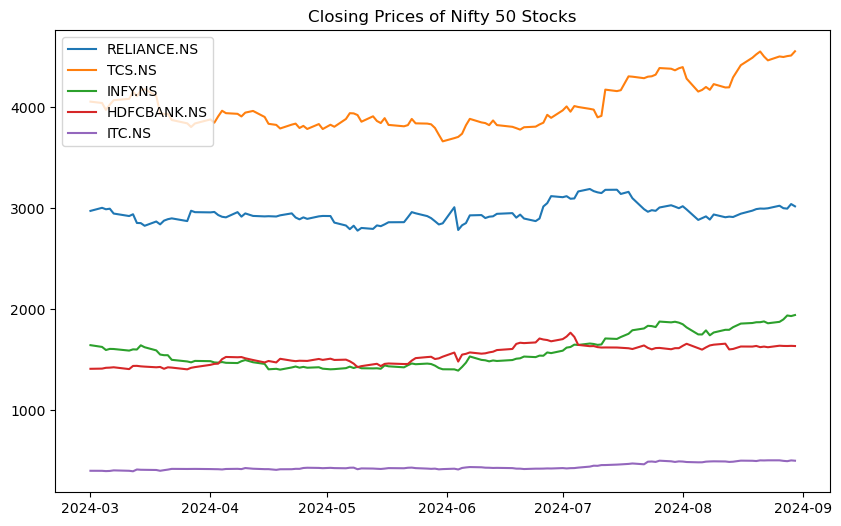

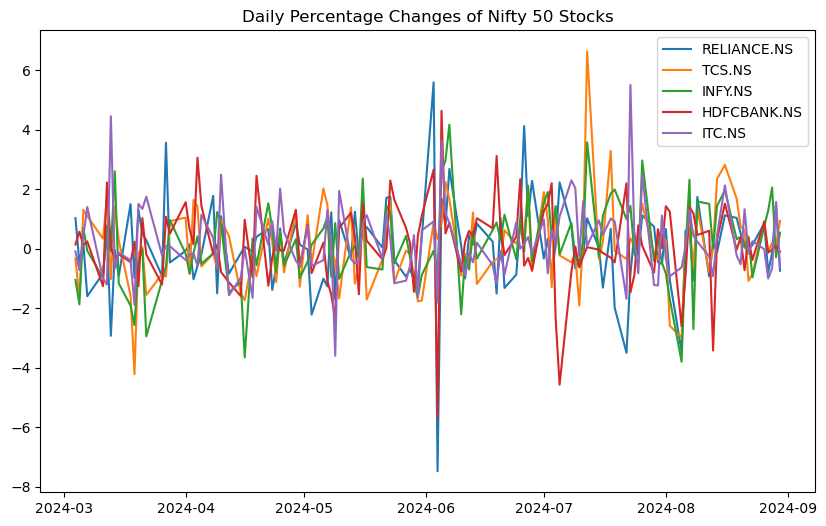

In [9]:
import matplotlib.pyplot as plt

# Plot closing prices
plt.figure(figsize=(10, 6))
for stock in stock_symbols:
    plt.plot(stock_data[stock].index, stock_data[stock]['Adj Close'], label=stock)
plt.title('Closing Prices of Nifty 50 Stocks')
plt.legend()
plt.show()

# Plot daily percentage changes
plt.figure(figsize=(10, 6))
for stock in stock_symbols:
    plt.plot(stock_data[stock].index, stock_data[stock]['Daily % Change'], label=stock)
plt.title('Daily Percentage Changes of Nifty 50 Stocks')
plt.legend()
plt.show()


In [11]:
for stock in stock_data:
    stock_data[stock]['20-day MA'] = stock_data[stock]['Adj Close'].rolling(window=20).mean()

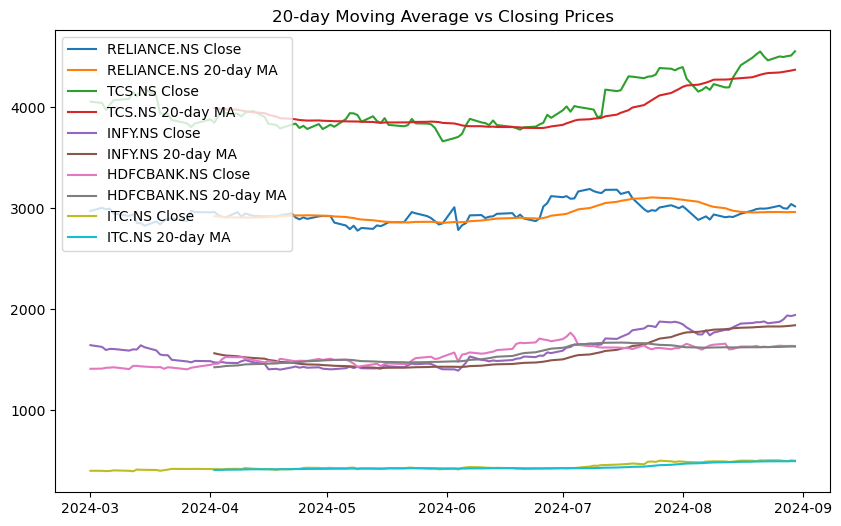

In [13]:
plt.figure(figsize=(10, 6))
for stock in stock_symbols:
    plt.plot(stock_data[stock].index, stock_data[stock]['Adj Close'], label=f'{stock} Close')
    plt.plot(stock_data[stock].index, stock_data[stock]['20-day MA'], label=f'{stock} 20-day MA')
plt.title('20-day Moving Average vs Closing Prices')
plt.legend()
plt.show()

### Task 2: Strategy Development

In [15]:
stock = 'RELIANCE.NS'
stock_data[stock]['50-day MA'] = stock_data[stock]['Adj Close'].rolling(window=50).mean()
stock_data[stock]['200-day MA'] = stock_data[stock]['Adj Close'].rolling(window=200).mean()

In [22]:
def backtest_strategy(data):
    buy_signals = []
    sell_signals = []
    position = False  # Track if we hold the stock

    for i in range(len(data)):
        if data['50-day MA'].iloc[i] > data['200-day MA'].iloc[i] and not position:
            buy_signals.append(data['Adj Close'].iloc[i])
            sell_signals.append(float('nan'))
            position = True
        elif data['50-day MA'].iloc[i] < data['200-day MA'].iloc[i] and position:
            sell_signals.append(data['Adj Close'].iloc[i])
            buy_signals.append(float('nan'))
            position = False
        else:
            buy_signals.append(float('nan'))
            sell_signals.append(float('nan'))
    return buy_signals, sell_signals

buy, sell = backtest_strategy(stock_data[stock])
stock_data[stock]['Buy Signals'] = buy
stock_data[stock]['Sell Signals'] = sell

In [26]:
buy_and_hold_return = (stock_data[stock]['Adj Close'].iloc[-1] - stock_data[stock]['Adj Close'].iloc[0]) / stock_data[stock]['Adj Close'].iloc[0]

### Task 3: Risk Management

In [28]:
def calculate_max_drawdown(data):
    data['Cumulative Max'] = data['Adj Close'].cummax()
    data['Drawdown'] = data['Adj Close'] / data['Cumulative Max'] - 1
    max_drawdown = data['Drawdown'].min()
    return max_drawdown

max_drawdowns = {stock: calculate_max_drawdown(stock_data[stock]) for stock in stock_data}

In [32]:
stop_loss = 0.05
def apply_stop_loss(data, stop_loss):
    signals = backtest_strategy(data)
    for i in range(1, len(data)):
        if data['Adj Close'].iloc[i] < data['Adj Close'].iloc[i-1] * (1 - stop_loss):
            signals[1][i] = data['Adj Close'].iloc[i]  # Sell due to stop-loss
    return signals

buy_with_sl, sell_with_sl = apply_stop_loss(stock_data[stock], stop_loss)